In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from xgboost import XGBRegressor

In [4]:
df = pd.read_excel('dataset_final.xlsx')

In [4]:
df['RR_1'] = df['RR'].shift(1)
df['RR_2'] = df['RR'].shift(2)
df['RR_3'] = df['RR'].shift(3)

# Hapus baris NaN akibat pergeseran
df = df.dropna()

# Tentukan fitur dan target
X = df[['TN', 'TX', 'TAVG', 'RH_AVG', 'SS', 'FF_X', 'DDD_X', 'FF_AVG', 'RR_1', 'RR_2', 'RR_3']]
y = df['RR']  # Target curah hujan hari ini

# ==============================================
# 3️⃣ Split Data Train & Test
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # time series → tidak diacak
)

# ==============================================
# 4️⃣ Inisialisasi Model Awal
# ==============================================
model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# ==============================================
# 5️⃣ Tuning Hyperparameter dengan GridSearchCV
# ==============================================
param_grid = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# ==============================================
# 6️⃣ Model Terbaik dari Tuning
# ==============================================
best_model = grid_search.best_estimator_

# ==============================================
# 7️⃣ Evaluasi Model
# ==============================================
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Evaluation Result ===")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# ==============================================
# 8️⃣ Contoh Prediksi Hari Esok
# ==============================================
# Jika kamu ingin memprediksi curah hujan besok berdasarkan 3 hari terakhir:
latest_data = X.iloc[-1:].copy()  # ambil baris terakhir dari data
predicted_rain = best_model.predict(latest_data)[0]
print(f"\nPrediksi Curah Hujan Esok Hari: {predicted_rain:.2f} mm")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 1.0}

=== Evaluation Result ===
Mean Absolute Error (MAE): 6.824
Mean Squared Error (MSE): 174.913
Root Mean Squared Error (RMSE): 13.225
R² Score: 0.211

Prediksi Curah Hujan Esok Hari: 3.42 mm


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 600, 'subsample': 0.8}

=== Evaluation Result ===
MAE  : 2.251
MSE  : 37.708
RMSE : 6.141
R²   : 0.830


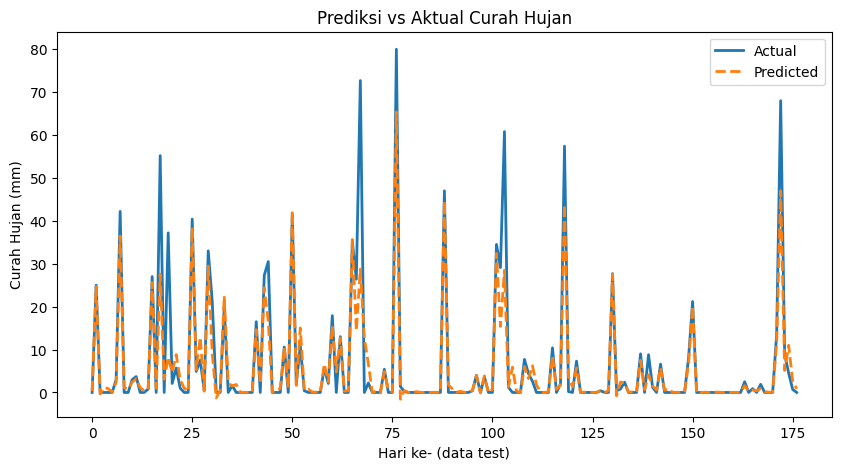


🌦️ Prediksi Curah Hujan Esok Hari: 0.84 mm


In [5]:
# ==============================================
# 1️⃣ Import Library
# ==============================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ==============================================
# 2️⃣ Siapkan Data
# ==============================================
# Asumsi df sudah bersih dan kolom 'TANGGAL' bertipe datetime
# Target: prediksi RR (curah hujan hari ini)

# Buat fitur waktu
df['month'] = df['TANGGAL'].dt.month
df['day'] = df['TANGGAL'].dt.day
df['dayofyear'] = df['TANGGAL'].dt.dayofyear

# Buat fitur lag (hari sebelumnya)
df['RR_1'] = df['RR'].shift(1)
df['RR_2'] = df['RR'].shift(2)
df['RR_3'] = df['RR'].shift(3)

# Buat rolling mean (rata-rata curah hujan 3 hari terakhir)
df['RR_mean3'] = df['RR'].rolling(window=3).mean()

# Apakah kemarin hujan?
df['is_rainy_yesterday'] = (df['RR_1'] > 0).astype(int)

# Hapus baris NaN akibat shift & rolling
df = df.dropna().reset_index(drop=True)

# ==============================================
# 3️⃣ Pisahkan Fitur & Target
# ==============================================
X = df[['TN', 'TX', 'TAVG', 'RH_AVG', 'SS', 'FF_X', 'DDD_X', 'FF_AVG',
        'RR_1', 'RR_2', 'RR_3', 'RR_mean3', 'month', 'dayofyear', 'is_rainy_yesterday']]
y = df['RR']

# Split data (tanpa shuffle karena time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ==============================================
# 4️⃣ Inisialisasi Model & Tuning Ringan
# ==============================================
model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# ==============================================
# 5️⃣ Model Terbaik & Evaluasi
# ==============================================
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Evaluation Result ===")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

# ==============================================
# 6️⃣ Visualisasi Hasil
# ==============================================
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title('Prediksi vs Aktual Curah Hujan')
plt.xlabel('Hari ke- (data test)')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.show()

# ==============================================
# 7️⃣ Prediksi Hari Esok
# ==============================================
latest_data = X.iloc[-1:].copy()
predicted_rain = best_model.predict(latest_data)[0]
print(f"\n🌦️ Prediksi Curah Hujan Esok Hari: {predicted_rain:.2f} mm")


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# ======================================
# 1️⃣ Persiapan Data
# ======================================

# Pastikan TANGGAL bertipe datetime
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'])

# Buat fitur waktu
df['month'] = df['TANGGAL'].dt.month
df['day'] = df['TANGGAL'].dt.day
df['dayofweek'] = df['TANGGAL'].dt.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

# Buat fitur lag curah hujan sebelumnya
df['RR_1'] = df['RR'].shift(1)
df['RR_2'] = df['RR'].shift(2)
df['RR_3'] = df['RR'].shift(3)

# Buat fitur rolling mean (rata-rata 3 hari terakhir)
df['RR_rolling3'] = df['RR'].shift(1).rolling(window=3).mean()

# Hapus baris NaN akibat pergeseran
df = df.dropna()

# ======================================
# 2️⃣ Pilih Fitur dan Target
# ======================================

fitur = ['TN', 'TX', 'TAVG', 'RH_AVG', 'SS', 'FF_X', 'DDD_X', 'FF_AVG',
          'month', 'day', 'dayofweek', 'is_weekend',
          'RR_1', 'RR_2', 'RR_3', 'RR_rolling3']

X = df[fitur]
y = df['RR']

# ======================================
# 3️⃣ Split Data Train & Test
# ======================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # tanpa shuffle karena data waktu
)

# ======================================
# 4️⃣ Model XGBoost
# ======================================
model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    n_estimators=400,
    max_depth=3,
    min_child_weight=3,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# ======================================
# 5️⃣ Evaluasi Model
# ======================================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=== Evaluation Result ===")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

# ======================================
# 6️⃣ Prediksi Curah Hujan Esok Hari
# ======================================

# Ambil data terakhir (baris paling akhir)
last_row = df.iloc[-1:].copy()

# Update lag & rolling mean untuk prediksi hari berikutnya
last_row['RR_1'] = last_row['RR']
last_row['RR_2'] = df.iloc[-2]['RR']
last_row['RR_3'] = df.iloc[-3]['RR']
last_row['RR_rolling3'] = df['RR'].tail(3).mean()

# Geser tanggal ke hari berikutnya
last_row['TANGGAL'] = last_row['TANGGAL'] + pd.Timedelta(days=1)
last_row['month'] = last_row['TANGGAL'].dt.month
last_row['day'] = last_row['TANGGAL'].dt.day
last_row['dayofweek'] = last_row['TANGGAL'].dt.dayofweek
last_row['is_weekend'] = (last_row['dayofweek'] >= 5).astype(int)

X_next = last_row[fitur]

pred_next = model.predict(X_next)[0]
print(f"\nPrediksi Curah Hujan Esok Hari: {pred_next:.2f} mm")


=== Evaluation Result ===
MAE  : 6.885
MSE  : 189.147
RMSE : 13.753
R²   : 0.148

Prediksi Curah Hujan Esok Hari: 3.41 mm


In [6]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------- ----------- 1.0/1.5 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 7.3 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install optuna

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ------------------- -------------------- 1.0/2.1 MB 4.9 MB/s eta 0:00:01
   ---------------------------------- ----- 1.8/2.1 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 4.2 MB/s  0:00:00

   ---------------------------------------- 0/8 [PyYAML]
   ---------------------------------------- 0/8 [PyYAML]
   ---------------------------------------- 0/8 [PyYAML]
   ---------------------------------------- 0/8 [PyYAML]
   ---------------------------------------- 0/8 [PyYAML]
   ---------------------------------------- 0/8 [PyYAML]
   ---------------------------------------- 0/8 [PyYAML]
   ---------------------------------------- 0/8 [PyYAML]
   ---------------------------------------- 0/8 [PyYAML]
   ----- ---------------------------------- 1/8 [MarkupSafe]
   ----- ---------------------------------- 1/8 [MarkupSafe]
   ----- ---------------------------------- 1/8 [MarkupSafe]
   ------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Lenovo E15\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔧 Creating advanced features...


[I 2025-11-03 13:02:08,752] A new study created in memory with name: no-name-f8bfc529-b481-4c9b-9437-bb2ce93ed1a7


✅ Created 102 features total

📊 Data shape after feature engineering: (858, 102)
📈 Total features: 100
🔹 Train size: 686, Test size: 172

🔍 Starting hyperparameter optimization with Optuna...
   This may take 5-15 minutes depending on your machine...



Best trial: 0. Best value: 3.47324:   2%|▏         | 1/50 [00:07<06:23,  7.82s/it]

[I 2025-11-03 13:02:16,577] Trial 0 finished with value: 3.4732449304968775 and parameters: {'n_estimators': 1062, 'learning_rate': 0.0862735828664018, 'max_depth': 10, 'num_leaves': 98, 'min_child_samples': 24, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088, 'min_split_gain': 0.7080725777960455}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 0. Best value: 3.47324:   4%|▍         | 2/50 [00:08<03:03,  3.83s/it]

[I 2025-11-03 13:02:17,617] Trial 1 finished with value: 3.9027812343341566 and parameters: {'n_estimators': 530, 'learning_rate': 0.09138013915892866, 'max_depth': 11, 'num_leaves': 47, 'min_child_samples': 26, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'reg_alpha': 0.5247564316322378, 'reg_lambda': 0.43194501864211576, 'min_split_gain': 0.2912291401980419}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 0. Best value: 3.47324:   6%|▌         | 3/50 [00:10<02:22,  3.03s/it]

[I 2025-11-03 13:02:19,697] Trial 2 finished with value: 4.312713122876492 and parameters: {'n_estimators': 1418, 'learning_rate': 0.007593739613361234, 'max_depth': 5, 'num_leaves': 67, 'min_child_samples': 51, 'subsample': 0.9140703845572055, 'colsample_bytree': 0.6798695128633439, 'reg_alpha': 0.5142344384136116, 'reg_lambda': 0.5924145688620425, 'min_split_gain': 0.046450412719997725}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 0. Best value: 3.47324:   8%|▊         | 4/50 [00:12<01:46,  2.31s/it]

[I 2025-11-03 13:02:20,906] Trial 3 finished with value: 6.469763599437818 and parameters: {'n_estimators': 1411, 'learning_rate': 0.008333491643033208, 'max_depth': 3, 'num_leaves': 144, 'min_child_samples': 97, 'subsample': 0.9233589392465844, 'colsample_bytree': 0.7218455076693483, 'reg_alpha': 0.09767211400638387, 'reg_lambda': 0.6842330265121569, 'min_split_gain': 0.4401524937396013}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 0. Best value: 3.47324:  10%|█         | 5/50 [00:13<01:21,  1.82s/it]

[I 2025-11-03 13:02:21,842] Trial 4 finished with value: 3.7287343303430105 and parameters: {'n_estimators': 683, 'learning_rate': 0.022039920190846215, 'max_depth': 3, 'num_leaves': 139, 'min_child_samples': 33, 'subsample': 0.8650089137415928, 'colsample_bytree': 0.7246844304357644, 'reg_alpha': 0.5200680211778108, 'reg_lambda': 0.5467102793432796, 'min_split_gain': 0.18485445552552704}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 0. Best value: 3.47324:  12%|█▏        | 6/50 [00:16<01:40,  2.29s/it]

[I 2025-11-03 13:02:25,042] Trial 5 finished with value: 6.326521926635201 and parameters: {'n_estimators': 1955, 'learning_rate': 0.050984839695857445, 'max_depth': 12, 'num_leaves': 137, 'min_child_samples': 64, 'subsample': 0.9687496940092467, 'colsample_bytree': 0.6353970008207678, 'reg_alpha': 0.1959828624191452, 'reg_lambda': 0.045227288910538066, 'min_split_gain': 0.32533033076326434}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 0. Best value: 3.47324:  14%|█▍        | 7/50 [00:17<01:29,  2.07s/it]

[I 2025-11-03 13:02:26,670] Trial 6 finished with value: 3.7344440358588487 and parameters: {'n_estimators': 1083, 'learning_rate': 0.01127205849868025, 'max_depth': 11, 'num_leaves': 66, 'min_child_samples': 35, 'subsample': 0.8170784332632994, 'colsample_bytree': 0.6563696899899051, 'reg_alpha': 0.8021969807540397, 'reg_lambda': 0.07455064367977082, 'min_split_gain': 0.9868869366005173}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 0. Best value: 3.47324:  16%|█▌        | 8/50 [00:19<01:24,  2.01s/it]

[I 2025-11-03 13:02:28,541] Trial 7 finished with value: 5.684128348263676 and parameters: {'n_estimators': 1659, 'learning_rate': 0.009067865433891705, 'max_depth': 3, 'num_leaves': 126, 'min_child_samples': 74, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'reg_alpha': 0.07404465173409036, 'reg_lambda': 0.3584657285442726, 'min_split_gain': 0.11586905952512971}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 0. Best value: 3.47324:  18%|█▊        | 9/50 [00:22<01:31,  2.22s/it]

[I 2025-11-03 13:02:31,236] Trial 8 finished with value: 4.346953779429896 and parameters: {'n_estimators': 1795, 'learning_rate': 0.03235188302117385, 'max_depth': 6, 'num_leaves': 28, 'min_child_samples': 38, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'reg_alpha': 0.6375574713552131, 'reg_lambda': 0.8872127425763265, 'min_split_gain': 0.4722149251619493}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 0. Best value: 3.47324:  20%|██        | 10/50 [00:23<01:11,  1.79s/it]

[I 2025-11-03 13:02:32,055] Trial 9 finished with value: 6.023194666396255 and parameters: {'n_estimators': 679, 'learning_rate': 0.042356773126632795, 'max_depth': 10, 'num_leaves': 93, 'min_child_samples': 80, 'subsample': 0.7975182385457563, 'colsample_bytree': 0.8090931317527976, 'reg_alpha': 0.42754101835854963, 'reg_lambda': 0.02541912674409519, 'min_split_gain': 0.10789142699330445}. Best is trial 0 with value: 3.4732449304968775.


Best trial: 10. Best value: 2.22436:  22%|██▏       | 11/50 [00:24<01:02,  1.60s/it]

[I 2025-11-03 13:02:33,238] Trial 10 finished with value: 2.224361828964582 and parameters: {'n_estimators': 1062, 'learning_rate': 0.08178081760009727, 'max_depth': 9, 'num_leaves': 105, 'min_child_samples': 11, 'subsample': 0.6154900799844731, 'colsample_bytree': 0.9839082983781678, 'reg_alpha': 0.9761398998579952, 'reg_lambda': 0.9469618763901493, 'min_split_gain': 0.7384055447250206}. Best is trial 10 with value: 2.224361828964582.


Best trial: 10. Best value: 2.22436:  24%|██▍       | 12/50 [00:25<00:54,  1.45s/it]

[I 2025-11-03 13:02:34,324] Trial 11 finished with value: 2.2615072919925736 and parameters: {'n_estimators': 1019, 'learning_rate': 0.08501524685764594, 'max_depth': 9, 'num_leaves': 104, 'min_child_samples': 11, 'subsample': 0.6047606839380596, 'colsample_bytree': 0.996380128364447, 'reg_alpha': 0.9989416392138661, 'reg_lambda': 0.9496601242269059, 'min_split_gain': 0.7808078155721442}. Best is trial 10 with value: 2.224361828964582.


Best trial: 10. Best value: 2.22436:  26%|██▌       | 13/50 [00:26<00:52,  1.43s/it]

[I 2025-11-03 13:02:35,706] Trial 12 finished with value: 2.523572962285718 and parameters: {'n_estimators': 936, 'learning_rate': 0.06115657223823307, 'max_depth': 8, 'num_leaves': 115, 'min_child_samples': 12, 'subsample': 0.6134343539737889, 'colsample_bytree': 0.9968147883372204, 'reg_alpha': 0.9960165317474352, 'reg_lambda': 0.9894373526172374, 'min_split_gain': 0.7150564905787808}. Best is trial 10 with value: 2.224361828964582.


Best trial: 10. Best value: 2.22436:  28%|██▊       | 14/50 [00:29<01:00,  1.69s/it]

[I 2025-11-03 13:02:37,988] Trial 13 finished with value: 2.4750263178995633 and parameters: {'n_estimators': 1235, 'learning_rate': 0.02196552023352846, 'max_depth': 8, 'num_leaves': 106, 'min_child_samples': 12, 'subsample': 0.6075182773179265, 'colsample_bytree': 0.9947869042037216, 'reg_alpha': 0.965337946065455, 'reg_lambda': 0.8080660344471642, 'min_split_gain': 0.7488571071611188}. Best is trial 10 with value: 2.224361828964582.


Best trial: 10. Best value: 2.22436:  30%|███       | 15/50 [00:30<00:53,  1.53s/it]

[I 2025-11-03 13:02:39,163] Trial 14 finished with value: 5.078987595193975 and parameters: {'n_estimators': 805, 'learning_rate': 0.06467416066705992, 'max_depth': 9, 'num_leaves': 76, 'min_child_samples': 51, 'subsample': 0.7141479150655654, 'colsample_bytree': 0.9199590390396316, 'reg_alpha': 0.7566736786723703, 'reg_lambda': 0.792323789373013, 'min_split_gain': 0.8924639199676936}. Best is trial 10 with value: 2.224361828964582.


Best trial: 15. Best value: 2.13522:  32%|███▏      | 16/50 [00:32<00:56,  1.66s/it]

[I 2025-11-03 13:02:41,116] Trial 15 finished with value: 2.1352211011852122 and parameters: {'n_estimators': 1343, 'learning_rate': 0.030746476256570718, 'max_depth': 6, 'num_leaves': 116, 'min_child_samples': 10, 'subsample': 0.6575200354740318, 'colsample_bytree': 0.9481404729080235, 'reg_alpha': 0.705533452860424, 'reg_lambda': 0.9560368195640884, 'min_split_gain': 0.5955828320895167}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  34%|███▍      | 17/50 [00:35<01:05,  1.98s/it]

[I 2025-11-03 13:02:43,835] Trial 16 finished with value: 3.2342667661431252 and parameters: {'n_estimators': 1398, 'learning_rate': 0.013910313659186472, 'max_depth': 6, 'num_leaves': 119, 'min_child_samples': 23, 'subsample': 0.7445247416006613, 'colsample_bytree': 0.8395522639506581, 'reg_alpha': 0.6896744252117673, 'reg_lambda': 0.22177409537475767, 'min_split_gain': 0.5663085841262694}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  36%|███▌      | 18/50 [00:37<01:07,  2.11s/it]

[I 2025-11-03 13:02:46,250] Trial 17 finished with value: 4.564433689173883 and parameters: {'n_estimators': 1629, 'learning_rate': 0.0340539032391954, 'max_depth': 5, 'num_leaves': 86, 'min_child_samples': 43, 'subsample': 0.6680084385252382, 'colsample_bytree': 0.946015385190579, 'reg_alpha': 0.3491039673293, 'reg_lambda': 0.7420635618680627, 'min_split_gain': 0.614452267258645}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  38%|███▊      | 19/50 [00:40<01:10,  2.26s/it]

[I 2025-11-03 13:02:48,874] Trial 18 finished with value: 2.781557126512121 and parameters: {'n_estimators': 1234, 'learning_rate': 0.005363041932862803, 'max_depth': 7, 'num_leaves': 126, 'min_child_samples': 22, 'subsample': 0.7809475172113585, 'colsample_bytree': 0.8556428991631608, 'reg_alpha': 0.8739330888411408, 'reg_lambda': 0.876380869487793, 'min_split_gain': 0.8682270042463711}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  40%|████      | 20/50 [00:41<01:01,  2.06s/it]

[I 2025-11-03 13:02:50,456] Trial 19 finished with value: 6.552060523404808 and parameters: {'n_estimators': 1580, 'learning_rate': 0.015921577779021874, 'max_depth': 7, 'num_leaves': 111, 'min_child_samples': 94, 'subsample': 0.6475335808777957, 'colsample_bytree': 0.9516520290227313, 'reg_alpha': 0.6572415663875772, 'reg_lambda': 0.6775580769615622, 'min_split_gain': 0.6144017786241942}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  42%|████▏     | 21/50 [00:43<00:55,  1.90s/it]

[I 2025-11-03 13:02:51,977] Trial 20 finished with value: 5.273791786885321 and parameters: {'n_estimators': 1222, 'learning_rate': 0.029904946879998617, 'max_depth': 5, 'num_leaves': 76, 'min_child_samples': 59, 'subsample': 0.7016407067573106, 'colsample_bytree': 0.7829669340138108, 'reg_alpha': 0.878627006583033, 'reg_lambda': 0.8777037991257596, 'min_split_gain': 0.532325925139082}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  44%|████▍     | 22/50 [00:44<00:45,  1.62s/it]

[I 2025-11-03 13:02:52,943] Trial 21 finished with value: 2.214838250292792 and parameters: {'n_estimators': 1012, 'learning_rate': 0.09790092939031522, 'max_depth': 9, 'num_leaves': 101, 'min_child_samples': 11, 'subsample': 0.6051813844826244, 'colsample_bytree': 0.9632922320007935, 'reg_alpha': 0.9864480439774893, 'reg_lambda': 0.9827684441673252, 'min_split_gain': 0.802355922497679}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  46%|████▌     | 23/50 [00:45<00:41,  1.52s/it]

[I 2025-11-03 13:02:54,248] Trial 22 finished with value: 2.8023063082319766 and parameters: {'n_estimators': 880, 'learning_rate': 0.06705368648731319, 'max_depth': 9, 'num_leaves': 93, 'min_child_samples': 18, 'subsample': 0.6417422072358038, 'colsample_bytree': 0.9480076758322988, 'reg_alpha': 0.7401744391094025, 'reg_lambda': 0.9677532509378728, 'min_split_gain': 0.8428146683505219}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  48%|████▊     | 24/50 [00:47<00:42,  1.62s/it]

[I 2025-11-03 13:02:56,079] Trial 23 finished with value: 3.9195621008067505 and parameters: {'n_estimators': 1131, 'learning_rate': 0.04416581925846929, 'max_depth': 8, 'num_leaves': 126, 'min_child_samples': 29, 'subsample': 0.6959182463558695, 'colsample_bytree': 0.8760977632791143, 'reg_alpha': 0.9138177497575839, 'reg_lambda': 0.8389848435812575, 'min_split_gain': 0.6637739581554057}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  50%|█████     | 25/50 [00:48<00:38,  1.53s/it]

[I 2025-11-03 13:02:57,411] Trial 24 finished with value: 2.7313681467935975 and parameters: {'n_estimators': 1313, 'learning_rate': 0.09707895328620758, 'max_depth': 10, 'num_leaves': 83, 'min_child_samples': 17, 'subsample': 0.6372882649170817, 'colsample_bytree': 0.9509449385844679, 'reg_alpha': 0.6140709102234133, 'reg_lambda': 0.9335394555954106, 'min_split_gain': 0.9909776637868204}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  52%|█████▏    | 26/50 [00:49<00:33,  1.38s/it]

[I 2025-11-03 13:02:58,448] Trial 25 finished with value: 2.1686754013608156 and parameters: {'n_estimators': 937, 'learning_rate': 0.0690610450545424, 'max_depth': 6, 'num_leaves': 102, 'min_child_samples': 10, 'subsample': 0.7656973816448874, 'colsample_bytree': 0.9619181129905612, 'reg_alpha': 0.808509278102109, 'reg_lambda': 0.7368005145838272, 'min_split_gain': 0.81293653433831}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  54%|█████▍    | 27/50 [00:50<00:31,  1.35s/it]

[I 2025-11-03 13:02:59,723] Trial 26 finished with value: 4.236889745991712 and parameters: {'n_estimators': 816, 'learning_rate': 0.04956835937945238, 'max_depth': 6, 'num_leaves': 52, 'min_child_samples': 41, 'subsample': 0.7520735588989015, 'colsample_bytree': 0.922105882103117, 'reg_alpha': 0.8436879779436994, 'reg_lambda': 0.692935698033841, 'min_split_gain': 0.815981592450115}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  56%|█████▌    | 28/50 [00:52<00:30,  1.40s/it]

[I 2025-11-03 13:03:01,248] Trial 27 finished with value: 2.6189855986632207 and parameters: {'n_estimators': 944, 'learning_rate': 0.025672917239633216, 'max_depth': 4, 'num_leaves': 118, 'min_child_samples': 18, 'subsample': 0.7690791703456051, 'colsample_bytree': 0.9691557573464815, 'reg_alpha': 0.7734291031918956, 'reg_lambda': 0.7549840918750789, 'min_split_gain': 0.9178784424987732}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  58%|█████▊    | 29/50 [00:54<00:32,  1.53s/it]

[I 2025-11-03 13:03:03,063] Trial 28 finished with value: 4.223275616781047 and parameters: {'n_estimators': 1503, 'learning_rate': 0.0694667568300964, 'max_depth': 7, 'num_leaves': 148, 'min_child_samples': 30, 'subsample': 0.8346273637462154, 'colsample_bytree': 0.8208660874633481, 'reg_alpha': 0.5776905700805783, 'reg_lambda': 0.8361691551560304, 'min_split_gain': 0.6562968560186255}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  60%|██████    | 30/50 [00:55<00:30,  1.53s/it]

[I 2025-11-03 13:03:04,599] Trial 29 finished with value: 2.8098867699712855 and parameters: {'n_estimators': 717, 'learning_rate': 0.01688056224702517, 'max_depth': 6, 'num_leaves': 94, 'min_child_samples': 20, 'subsample': 0.6963426595119917, 'colsample_bytree': 0.8830877982982436, 'reg_alpha': 0.6975654951389404, 'reg_lambda': 0.6141404108154256, 'min_split_gain': 0.4008657445169629}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  62%|██████▏   | 31/50 [00:57<00:30,  1.62s/it]

[I 2025-11-03 13:03:06,426] Trial 30 finished with value: 3.258088042691138 and parameters: {'n_estimators': 1160, 'learning_rate': 0.03725874539023158, 'max_depth': 4, 'num_leaves': 102, 'min_child_samples': 25, 'subsample': 0.6632163695926466, 'colsample_bytree': 0.9261604341553287, 'reg_alpha': 0.9105444378321985, 'reg_lambda': 0.4474379765725054, 'min_split_gain': 0.9402307747126584}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 15. Best value: 2.13522:  64%|██████▍   | 32/50 [00:58<00:25,  1.43s/it]

[I 2025-11-03 13:03:07,403] Trial 31 finished with value: 2.2387399731314073 and parameters: {'n_estimators': 1026, 'learning_rate': 0.08679506569240304, 'max_depth': 9, 'num_leaves': 109, 'min_child_samples': 11, 'subsample': 0.634679047962791, 'colsample_bytree': 0.9734465393242449, 'reg_alpha': 0.9360815968681608, 'reg_lambda': 0.910041805204138, 'min_split_gain': 0.759097021006038}. Best is trial 15 with value: 2.1352211011852122.


Best trial: 32. Best value: 2.10712:  66%|██████▌   | 33/50 [00:59<00:22,  1.32s/it]

[I 2025-11-03 13:03:08,484] Trial 32 finished with value: 2.1071214059576913 and parameters: {'n_estimators': 992, 'learning_rate': 0.07472276972428356, 'max_depth': 11, 'num_leaves': 99, 'min_child_samples': 10, 'subsample': 0.6228750231722042, 'colsample_bytree': 0.9787486328849248, 'reg_alpha': 0.8232037916449929, 'reg_lambda': 0.9838591752071254, 'min_split_gain': 0.6937168561240429}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  68%|██████▊   | 34/50 [01:00<00:19,  1.23s/it]

[I 2025-11-03 13:03:09,506] Trial 33 finished with value: 2.738046454586559 and parameters: {'n_estimators': 572, 'learning_rate': 0.05479880351011242, 'max_depth': 12, 'num_leaves': 97, 'min_child_samples': 17, 'subsample': 0.6845150275236065, 'colsample_bytree': 0.7742869158657634, 'reg_alpha': 0.8220328693359599, 'reg_lambda': 0.9954475809869406, 'min_split_gain': 0.8212780617376393}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  70%|███████   | 35/50 [01:02<00:19,  1.28s/it]

[I 2025-11-03 13:03:10,889] Trial 34 finished with value: 3.747868041296492 and parameters: {'n_estimators': 958, 'learning_rate': 0.07477765828353762, 'max_depth': 11, 'num_leaves': 87, 'min_child_samples': 27, 'subsample': 0.6618928310896987, 'colsample_bytree': 0.9592013518563645, 'reg_alpha': 0.8189781485343486, 'reg_lambda': 0.9978488622048994, 'min_split_gain': 0.6863483463102653}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  72%|███████▏  | 36/50 [01:03<00:19,  1.39s/it]

[I 2025-11-03 13:03:12,551] Trial 35 finished with value: 2.6530872918425 and parameters: {'n_estimators': 1313, 'learning_rate': 0.057232232455732966, 'max_depth': 10, 'num_leaves': 77, 'min_child_samples': 16, 'subsample': 0.7225050464893267, 'colsample_bytree': 0.9286974554981999, 'reg_alpha': 0.7187352008111625, 'reg_lambda': 0.7461534873654504, 'min_split_gain': 0.5742395669937479}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  74%|███████▍  | 37/50 [01:05<00:17,  1.34s/it]

[I 2025-11-03 13:03:13,776] Trial 36 finished with value: 3.5361882355533747 and parameters: {'n_estimators': 800, 'learning_rate': 0.0966319366989609, 'max_depth': 11, 'num_leaves': 130, 'min_child_samples': 24, 'subsample': 0.6388303087511908, 'colsample_bytree': 0.8950256299971565, 'reg_alpha': 0.5688176998681455, 'reg_lambda': 0.5924991803588647, 'min_split_gain': 0.6209152017346018}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  76%|███████▌  | 38/50 [01:06<00:15,  1.25s/it]

[I 2025-11-03 13:03:14,812] Trial 37 finished with value: 2.1749419874212994 and parameters: {'n_estimators': 1319, 'learning_rate': 0.07570807469416997, 'max_depth': 12, 'num_leaves': 65, 'min_child_samples': 10, 'subsample': 0.8374309222585637, 'colsample_bytree': 0.6005800047171014, 'reg_alpha': 0.8722488864313952, 'reg_lambda': 0.8615094552163195, 'min_split_gain': 0.5028208799859624}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  78%|███████▊  | 39/50 [01:08<00:16,  1.50s/it]

[I 2025-11-03 13:03:16,880] Trial 38 finished with value: 4.189727006571671 and parameters: {'n_estimators': 1468, 'learning_rate': 0.04171129979369522, 'max_depth': 12, 'num_leaves': 61, 'min_child_samples': 33, 'subsample': 0.8517779535311699, 'colsample_bytree': 0.6059202522570125, 'reg_alpha': 0.4617600914006707, 'reg_lambda': 0.8559386564888847, 'min_split_gain': 0.4014852707044879}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  80%|████████  | 40/50 [01:09<00:15,  1.51s/it]

[I 2025-11-03 13:03:18,426] Trial 39 finished with value: 6.43184550879484 and parameters: {'n_estimators': 1313, 'learning_rate': 0.049197303403785586, 'max_depth': 11, 'num_leaves': 26, 'min_child_samples': 71, 'subsample': 0.8866743432540273, 'colsample_bytree': 0.6851465408840623, 'reg_alpha': 0.7775968648263891, 'reg_lambda': 0.6655327239653694, 'min_split_gain': 0.305019004815535}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  82%|████████▏ | 41/50 [01:11<00:15,  1.74s/it]

[I 2025-11-03 13:03:20,712] Trial 40 finished with value: 2.591850158386304 and parameters: {'n_estimators': 1357, 'learning_rate': 0.029273421794811048, 'max_depth': 12, 'num_leaves': 44, 'min_child_samples': 15, 'subsample': 0.9462176796688316, 'colsample_bytree': 0.752803405271306, 'reg_alpha': 0.018825163478298823, 'reg_lambda': 0.5183262314886887, 'min_split_gain': 0.5038758930950618}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  84%|████████▍ | 42/50 [01:12<00:12,  1.52s/it]

[I 2025-11-03 13:03:21,712] Trial 41 finished with value: 2.2022201668679884 and parameters: {'n_estimators': 1131, 'learning_rate': 0.07785135555382527, 'max_depth': 11, 'num_leaves': 62, 'min_child_samples': 10, 'subsample': 0.8071256030035835, 'colsample_bytree': 0.6840654773930064, 'reg_alpha': 0.8922007209354679, 'reg_lambda': 0.9201014318614449, 'min_split_gain': 0.7836685250824788}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  86%|████████▌ | 43/50 [01:14<00:10,  1.49s/it]

[I 2025-11-03 13:03:23,122] Trial 42 finished with value: 3.417921463272831 and parameters: {'n_estimators': 1176, 'learning_rate': 0.07826910336103472, 'max_depth': 12, 'num_leaves': 58, 'min_child_samples': 21, 'subsample': 0.8238914864551812, 'colsample_bytree': 0.6744255622298824, 'reg_alpha': 0.8888842338147663, 'reg_lambda': 0.9090088227840849, 'min_split_gain': 0.4542703996956253}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  88%|████████▊ | 44/50 [01:15<00:08,  1.41s/it]

[I 2025-11-03 13:03:24,353] Trial 43 finished with value: 2.165383228336709 and parameters: {'n_estimators': 1121, 'learning_rate': 0.07000080763908284, 'max_depth': 11, 'num_leaves': 40, 'min_child_samples': 10, 'subsample': 0.9992062925899448, 'colsample_bytree': 0.6303052620923153, 'reg_alpha': 0.8506687646751272, 'reg_lambda': 0.7826392304511594, 'min_split_gain': 0.2440698599516669}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  90%|█████████ | 45/50 [01:17<00:07,  1.56s/it]

[I 2025-11-03 13:03:26,271] Trial 44 finished with value: 2.6360459261659135 and parameters: {'n_estimators': 1754, 'learning_rate': 0.06097879993040327, 'max_depth': 10, 'num_leaves': 36, 'min_child_samples': 15, 'subsample': 0.9997285043934478, 'colsample_bytree': 0.6386103689525235, 'reg_alpha': 0.8284089484553364, 'reg_lambda': 0.8253264802066808, 'min_split_gain': 0.2538652956565832}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  92%|█████████▏| 46/50 [01:18<00:05,  1.37s/it]

[I 2025-11-03 13:03:27,184] Trial 45 finished with value: 6.7171881575944505 and parameters: {'n_estimators': 1090, 'learning_rate': 0.06908090099093432, 'max_depth': 11, 'num_leaves': 20, 'min_child_samples': 87, 'subsample': 0.921266379624042, 'colsample_bytree': 0.610693328612083, 'reg_alpha': 0.7779348751530704, 'reg_lambda': 0.7753543854090486, 'min_split_gain': 0.018656023183276305}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  94%|█████████▍| 47/50 [01:19<00:04,  1.41s/it]

[I 2025-11-03 13:03:28,684] Trial 46 finished with value: 2.480607246068911 and parameters: {'n_estimators': 1502, 'learning_rate': 0.053076224048523794, 'max_depth': 5, 'num_leaves': 49, 'min_child_samples': 14, 'subsample': 0.8942458448586774, 'colsample_bytree': 0.6377406715186251, 'reg_alpha': 0.3506332368207289, 'reg_lambda': 0.7044731263284936, 'min_split_gain': 0.3600078374626343}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  96%|█████████▌| 48/50 [01:21<00:02,  1.37s/it]

[I 2025-11-03 13:03:29,959] Trial 47 finished with value: 4.82663565298587 and parameters: {'n_estimators': 863, 'learning_rate': 0.044200105671195346, 'max_depth': 12, 'num_leaves': 40, 'min_child_samples': 50, 'subsample': 0.9499706844386189, 'colsample_bytree': 0.7035609217538863, 'reg_alpha': 0.6836633142902856, 'reg_lambda': 0.3040690724100081, 'min_split_gain': 0.22802197505517371}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712:  98%|█████████▊| 49/50 [01:23<00:01,  1.67s/it]

[I 2025-11-03 13:03:32,323] Trial 48 finished with value: 3.3886211113987095 and parameters: {'n_estimators': 1959, 'learning_rate': 0.03901153696457558, 'max_depth': 6, 'num_leaves': 138, 'min_child_samples': 21, 'subsample': 0.8578612959452738, 'colsample_bytree': 0.6576488447671696, 'reg_alpha': 0.8560861551725636, 'reg_lambda': 0.12958723799984528, 'min_split_gain': 0.5130198577708374}. Best is trial 32 with value: 2.1071214059576913.


Best trial: 32. Best value: 2.10712: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


[I 2025-11-03 13:03:34,007] Trial 49 finished with value: 4.31489560726669 and parameters: {'n_estimators': 1396, 'learning_rate': 0.0848782403728853, 'max_depth': 4, 'num_leaves': 114, 'min_child_samples': 31, 'subsample': 0.7834456664789092, 'colsample_bytree': 0.6003157796625759, 'reg_alpha': 0.9427526255592873, 'reg_lambda': 0.6416783316904213, 'min_split_gain': 0.12980770465527625}. Best is trial 32 with value: 2.1071214059576913.

✅ Optimization completed!
🏆 Best MAE: 2.1071
📋 Best parameters:
{'n_estimators': 992, 'learning_rate': 0.07472276972428356, 'max_depth': 11, 'num_leaves': 99, 'min_child_samples': 10, 'subsample': 0.6228750231722042, 'colsample_bytree': 0.9787486328849248, 'reg_alpha': 0.8232037916449929, 'reg_lambda': 0.9838591752071254, 'min_split_gain': 0.6937168561240429}

🚀 Training final model with best parameters...

📊 FINAL MODEL EVALUATION
MAE  : 1.026 mm
MSE  : 5.715
RMSE : 2.391 mm
R²   : 0.975

🔝 Top 15 Most Important Features:
          feature  importance


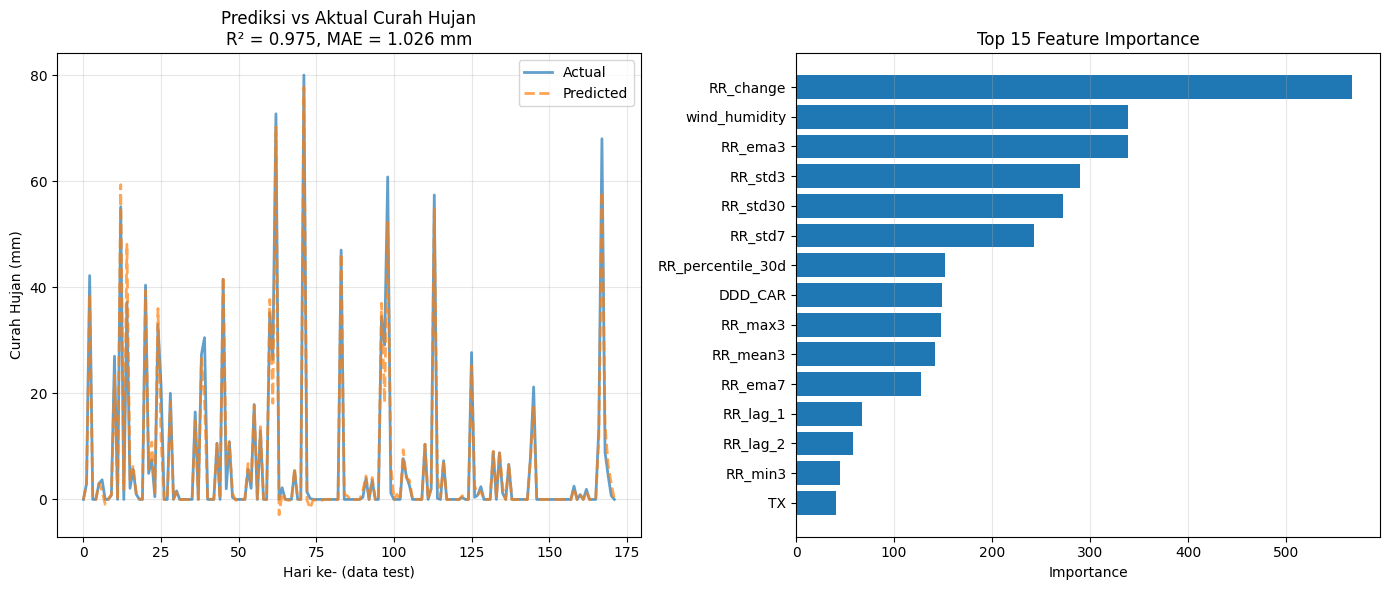


🌦️  PREDIKSI CURAH HUJAN ESOK HARI: 0.01 mm
📌 Status: Tidak hujan / Hujan sangat ringan
📊 Confidence interval (±1 std): -2.38 - 2.39 mm

✅ Process completed successfully!


In [9]:
# ==============================================
# 1️⃣ Import Library
# ==============================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ==============================================
# 2️⃣ FEATURE ENGINEERING ADVANCED
# ==============================================

def create_advanced_features(df):
    """
    Membuat fitur-fitur advanced untuk prediksi curah hujan
    """
    df = df.copy()
    
    print("🔧 Creating advanced features...")
    
    # ===== 1. FITUR TEMPORAL =====
    df['month'] = df['TANGGAL'].dt.month
    df['day'] = df['TANGGAL'].dt.day
    df['dayofyear'] = df['TANGGAL'].dt.dayofyear
    df['week'] = df['TANGGAL'].dt.isocalendar().week
    df['quarter'] = df['TANGGAL'].dt.quarter
    df['dayofweek'] = df['TANGGAL'].dt.dayofweek
    
    # Cyclical encoding (penting untuk capture pola musiman)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # Musim hujan Indonesia (Nov-Mar)
    df['is_rainy_season'] = df['month'].apply(lambda x: 1 if x in [11, 12, 1, 2, 3] else 0)
    
    # ===== 2. LAG FEATURES (1-7 hari sebelumnya) =====
    for i in range(1, 8):
        df[f'RR_lag{i}'] = df['RR'].shift(i)
    
    # Lag untuk fitur cuaca penting lainnya
    for col in ['TAVG', 'RH_AVG', 'FF_AVG', 'SS']:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag2'] = df[col].shift(2)
        df[f'{col}_lag3'] = df[col].shift(3)
    
    # ===== 3. ROLLING STATISTICS =====
    windows = [3, 7, 14, 30]
    
    for window in windows:
        # Curah hujan
        df[f'RR_mean{window}'] = df['RR'].rolling(window=window).mean()
        df[f'RR_max{window}'] = df['RR'].rolling(window=window).max()
        df[f'RR_min{window}'] = df['RR'].rolling(window=window).min()
        df[f'RR_std{window}'] = df['RR'].rolling(window=window).std()
        df[f'RR_sum{window}'] = df['RR'].rolling(window=window).sum()
        
        # Temperature
        df[f'TAVG_mean{window}'] = df['TAVG'].rolling(window=window).mean()
        df[f'TAVG_std{window}'] = df['TAVG'].rolling(window=window).std()
        
        # Humidity
        df[f'RH_AVG_mean{window}'] = df['RH_AVG'].rolling(window=window).mean()
        df[f'RH_AVG_std{window}'] = df['RH_AVG'].rolling(window=window).std()
    
    # ===== 4. TREND FEATURES =====
    # Hari berturut-turut hujan
    df['consecutive_rainy'] = (df['RR'] > 0).groupby((df['RR'] == 0).cumsum()).cumsum()
    
    # Hari berturut-turut kering
    df['consecutive_dry'] = (df['RR'] == 0).groupby((df['RR'] > 0).cumsum()).cumsum()
    
    # Jumlah hari hujan dalam periode tertentu
    df['rainy_days_7d'] = df['RR'].rolling(window=7).apply(lambda x: (x > 0).sum())
    df['rainy_days_14d'] = df['RR'].rolling(window=14).apply(lambda x: (x > 0).sum())
    df['rainy_days_30d'] = df['RR'].rolling(window=30).apply(lambda x: (x > 0).sum())
    
    # Apakah kemarin hujan?
    df['is_rainy_yesterday'] = (df['RR_lag1'] > 0).astype(int)
    df['is_rainy_2days_ago'] = (df['RR_lag2'] > 0).astype(int)
    
    # ===== 5. INTERACTION FEATURES =====
    df['temp_humidity'] = df['TAVG'] * df['RH_AVG']
    df['temp_range'] = df['TX'] - df['TN']
    df['sunshine_humidity'] = df['SS'] * (100 - df['RH_AVG'])
    df['wind_humidity'] = df['FF_AVG'] * df['RH_AVG']
    df['temp_wind'] = df['TAVG'] * df['FF_AVG']
    
    # ===== 6. EXPONENTIAL MOVING AVERAGE =====
    df['RR_ema3'] = df['RR'].ewm(span=3, adjust=False).mean()
    df['RR_ema7'] = df['RR'].ewm(span=7, adjust=False).mean()
    df['RH_AVG_ema7'] = df['RH_AVG'].ewm(span=7, adjust=False).mean()
    
    # ===== 7. RATE OF CHANGE =====
    df['RR_change'] = df['RR'].diff()
    df['TAVG_change'] = df['TAVG'].diff()
    df['RH_AVG_change'] = df['RH_AVG'].diff()
    
    # ===== 8. PERCENTILE FEATURES =====
    df['RR_percentile_30d'] = df['RR'].rolling(window=30).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
    )
    
    print(f"✅ Created {len(df.columns)} features total")
    
    return df

# ==============================================
# 3️⃣ Siapkan Data
# ==============================================

# Asumsi df sudah load dan TANGGAL sudah datetime
# df = pd.read_csv('your_data.csv')
# df['TANGGAL'] = pd.to_datetime(df['TANGGAL'])

df = create_advanced_features(df)

# Hapus baris NaN akibat shift & rolling
df_clean = df.dropna().reset_index(drop=True)

print(f"\n📊 Data shape after feature engineering: {df_clean.shape}")

# ==============================================
# 4️⃣ Pisahkan Fitur & Target
# ==============================================

# Kolom yang tidak dipakai untuk training
exclude_cols = ['TANGGAL', 'RR']

feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

X = df_clean[feature_cols]
y = df_clean['RR']

print(f"📈 Total features: {len(feature_cols)}")

# Split data (tanpa shuffle untuk time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"🔹 Train size: {len(X_train)}, Test size: {len(X_test)}")

# ==============================================
# 5️⃣ HYPERPARAMETER TUNING dengan OPTUNA
# ==============================================

def objective(trial):
    """
    Fungsi objective untuk Optuna
    """
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'random_state': 42
    }
    
    # Time Series Cross Validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    mae_scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LGBMRegressor(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
                  callbacks=[])
        
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mae_scores.append(mae)
    
    return np.mean(mae_scores)

print("\n🔍 Starting hyperparameter optimization with Optuna...")
print("   This may take 5-15 minutes depending on your machine...\n")

study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n✅ Optimization completed!")
print(f"🏆 Best MAE: {study.best_value:.4f}")
print(f"📋 Best parameters:\n{study.best_params}")

# ==============================================
# 6️⃣ Train Model dengan Best Parameters
# ==============================================

best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'random_state': 42
})

print("\n🚀 Training final model with best parameters...")

final_model = LGBMRegressor(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[]
)

# ==============================================
# 7️⃣ Evaluasi Model
# ==============================================

y_pred = final_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("📊 FINAL MODEL EVALUATION")
print("="*50)
print(f"MAE  : {mae:.3f} mm")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f} mm")
print(f"R²   : {r2:.3f}")
print("="*50)

# ==============================================
# 8️⃣ Feature Importance
# ==============================================

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# ==============================================
# 9️⃣ Visualisasi Hasil
# ==============================================

plt.figure(figsize=(14, 6))

# Plot 1: Prediksi vs Aktual
plt.subplot(1, 2, 1)
plt.plot(y_test.values, label='Actual', linewidth=2, alpha=0.7)
plt.plot(y_pred, label='Predicted', linestyle='--', linewidth=2, alpha=0.7)
plt.title(f'Prediksi vs Aktual Curah Hujan\nR² = {r2:.3f}, MAE = {mae:.3f} mm')
plt.xlabel('Hari ke- (data test)')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Feature Importance
plt.subplot(1, 2, 2)
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ==============================================
# 🔟 Prediksi Hari Esok
# ==============================================

latest_data = X.iloc[-1:].copy()
predicted_rain = final_model.predict(latest_data)[0]

print(f"\n🌦️  PREDIKSI CURAH HUJAN ESOK HARI: {predicted_rain:.2f} mm")

# Informasi tambahan
if predicted_rain < 1:
    status = "Tidak hujan / Hujan sangat ringan"
elif predicted_rain < 5:
    status = "Hujan ringan"
elif predicted_rain < 10:
    status = "Hujan sedang"
elif predicted_rain < 20:
    status = "Hujan lebat"
else:
    status = "Hujan sangat lebat"

print(f"📌 Status: {status}")

# Confidence interval (rough estimate)
std_error = np.std(y_test - y_pred)
print(f"📊 Confidence interval (±1 std): {predicted_rain - std_error:.2f} - {predicted_rain + std_error:.2f} mm")

print("\n✅ Process completed successfully!")